In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib
import os
import sys
import numpy as np
import cmocean.cm as ocm
from scipy.interpolate import griddata

proj_dir = os.path.join(os.pardir,os.pardir)
data_dir = os.path.join(proj_dir,'data','analysis')
fig_dir  = os.path.join(proj_dir,'reports','figures')
int_dir = os.path.join(data_dir,'interim')

src_dir = os.path.join(proj_dir,'src')
sys.path.append(src_dir)

from visualization.shiftedColorMap import shiftedColorMap
from roms_tools.cartesian_grid_2d import cartesian_grid_2d

tools_dir = os.path.join(proj_dir,'src','tools')
sys.path.append(tools_dir)
from rotate_vector_roms import rotate_vector_roms

In [141]:
grd_path = os.path.join(int_dir,'grd2_dV.nc')
grd = xr.open_dataset(grd_path)
mask_vostock = (grd.lat_rho<-75) & (grd.lat_rho>-80) & (grd.lon_rho>95) & (grd.lon_rho<115)
grd.mask_rho.values[mask_vostock]=0

#avg = xr.open_dataset(os.path.join(data_dir,'raw','waom10','ocean_avg_0009.nc'))

ubar_rho = xr.open_dataset(os.path.join(data_dir,'raw','waom2','ocean_avg_0538-0610_ubar_avg.nc')).ubar.mean('ocean_time')
vbar_rho = xr.open_dataset(os.path.join(data_dir,'raw','waom2','ocean_avg_0538-0610_vbar_avg.nc')).vbar.mean('ocean_time')
zeta = xr.open_dataset(os.path.join(data_dir,'raw','waom2','ocean_avg_0538-0610_zeta_avg.nc')).zeta.mean('ocean_time')

In [142]:
ubar_east,vbar_north = rotate_vector_roms(ubar_rho.values,vbar_rho.values,grd.angle.values)
#ubar_east,vbar_north = rotate_vector_roms(avg.ubar.mean('ocean_time').values,avg.vbar.mean('ocean_time').values,grd.angle.values)
wct = grd.h+grd.zice+zeta

In [4]:
ubar_east.data[np.isnan(ubar_east.data)]=0.0
wct.values[grd.mask_rho==0]=0

In [310]:
def rebin(a, shape):
    sh = shape[0],a.shape[0]//shape[0],shape[1],a.shape[1]//shape[1]
    return a.reshape(sh).mean(-1).mean(1)

In [298]:
ubar_east.shape[1]/2

1575.0

In [311]:
ubar_east = rebin(ubar_east,(1325,1575))
wct = rebin(wct.values,(1325,1575))
s_lat = rebin(grd.lat_rho.values,(1325,1575))
s_lon =rebin(grd.lon_rho.values,(1325,1575))

array([-131.98615694, -132.17685222, -132.36895893, ..., -180.97102195,
       -181.46880074, -183.01278753])

In [166]:
inp_res = 2
out_res = 0.1
t_lat = np.arange(-85,-50,out_res)
t_lon = np.arange(-180,180.05,out_res)
t_lon,t_lat = np.meshgrid(t_lon,t_lat)
s_lat = grd.lat_rho[::inp_res,::inp_res].values.flatten()
s_lon = grd.lon_rho[::inp_res,::inp_res].values.flatten()

lon_east = (s_lon<=180) & (s_lon>120)
lon_west = (s_lon<-120) & (s_lon>=-180)
ii = lon_east | lon_west

lon_tmp = s_lon[ii]
lon_extra = lon_tmp.copy()
lon_extra[lon_tmp<0]+=360
lon_extra[lon_tmp>0]-=360

s_lon = np.concatenate((s_lon,lon_extra))
s_lat = np.concatenate((s_lat,s_lat[ii]))

def regrid(s_dat): 
    s_dat = s_dat[::inp_res,::inp_res].flatten()
    s_dat = np.concatenate((s_dat,s_dat[ii]))
    reg =  griddata((s_lat,s_lon),s_dat,(t_lat,t_lon),method='linear',fill_value=0.0)
    reg[np.isnan(reg)] = 0
    return reg

In [167]:
%%time
ubar_ll = regrid(ubar_east.data)

CPU times: user 1min 14s, sys: 2.42 s, total: 1min 16s
Wall time: 1min 4s


In [168]:
wct_ll = regrid(wct.data)

In [169]:
dx,dy = cartesian_grid_2d(t_lon,t_lat)
print(dy.mean())
baro_strf = np.cumsum(ubar_ll*wct_ll*dy,axis=0)*1e-6

11119.49266445522


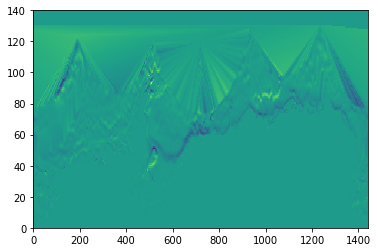

In [154]:
plt.pcolormesh(ubar_ll)

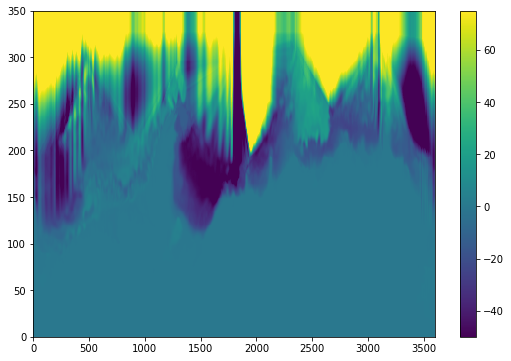

In [170]:
fig,ax = plt.subplots(figsize=(9,6))
plot = ax.pcolormesh(baro_strf,vmin=-50,vmax=75)
plt.colorbar(plot,ax=ax)

In [99]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean as cm
from dask.distributed import Client
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# Avoid the Runtime errors in true_divide encountered when trying to divide by zero
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)

In [100]:
client = Client(n_workers=16)

In [147]:
grd.lat_rho.max()

<xarray.DataArray 'lat_rho' ()>
array(-52.200244)

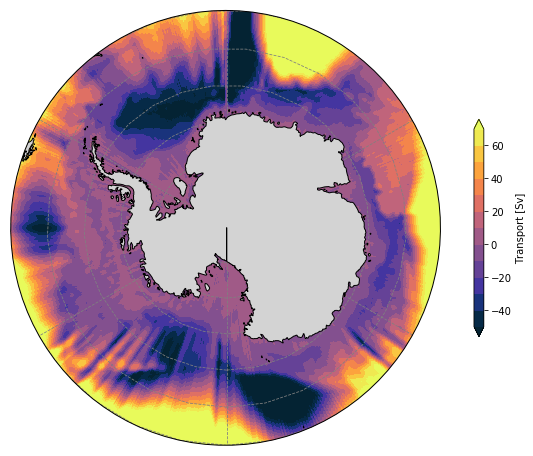

In [156]:
lvls = np.arange(-50, 75, 10)

fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111, projection = ccrs.SouthPolarStereo())
                     #,proj_kw={'llcrnrlon':-130, 'urcrnrlon':51, 'llcrnrlat':-54, 'urcrnrlat':-52})
ax.set_extent([-180, 180, -80, -54], crs=ccrs.PlateCarree())

# Map the plot boundaries to a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

# Add land features and gridlines
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='black',
               facecolor='lightgray'), zorder = 2)
ax.gridlines(color='grey', linestyle='--')

# Plot the barotropic stream function
cf = ax.contourf(t_lon, t_lat, baro_strf, levels = lvls, cmap = cm.cm.thermal,
                 extend = 'both', transform = ccrs.PlateCarree())

# Add a colorbar
cbar = fig.colorbar(cf, ax = ax, orientation = 'vertical', shrink = 0.5)
cbar.set_label('Transport [Sv]')

In [164]:
grd_path = os.path.join(int_dir,'grd10_dV.nc')
grd_10 = xr.open_dataset(grd_path)
baro_strf_rho = griddata((t_lat.flatten(),t_lon.flatten()),baro_strf.flatten(),
                         (grd_10.lat_rho[::1,::1],grd_10.lon_rho[::1,::1]),method='linear')

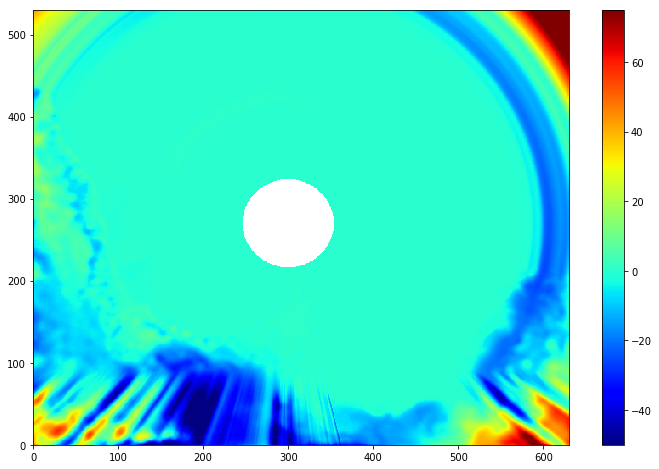

In [165]:
fig,ax = plt.subplots(figsize=(12,8))
plot = ax.pcolormesh(baro_strf_rho,cmap='jet',vmin=-50,vmax=75)
plt.colorbar(plot,ax=ax)

TRY LINEAR INTERPOLATION TO GO BACK!
try same inpu outp resolution (0.5 and 10)